<a href="https://colab.research.google.com/github/AnitaTasnim/GNN_attack_model/blob/main/attack_withi_riccicurvature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#import library

In [1]:
!pip install pygod
!pip install torch-geometric

In [2]:
import torch
import torch.nn as nn
from torch.nn import init
import torch_geometric
from pygod.utils import load_data
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures


In [3]:
import torch

In [4]:
import matplotlib.pyplot as plt

#about dataset

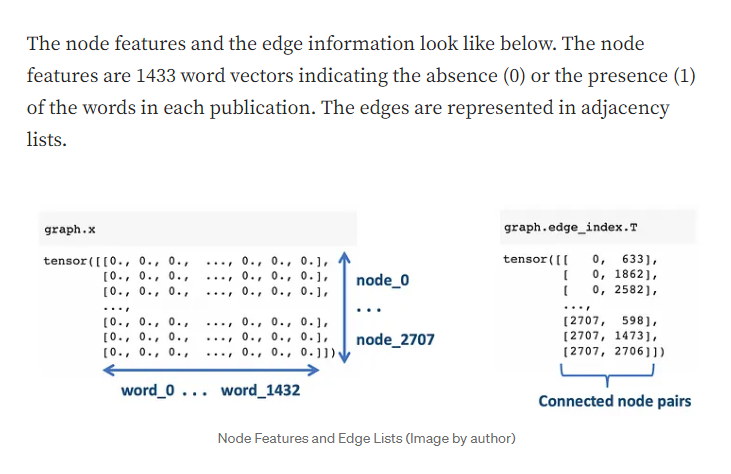

In [5]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='/tmp/Cora', name='Cora')
graph = dataset[0]

In [6]:
graph.x

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [7]:
graph

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [8]:
graph.edge_index.T #connected node pairs

tensor([[   0,  633],
        [   0, 1862],
        [   0, 2582],
        ...,
        [2707,  598],
        [2707, 1473],
        [2707, 2706]])

In [9]:
adj = dataset[0].edge_index.t() ## Get the adjacency matrix,
adj

tensor([[   0,  633],
        [   0, 1862],
        [   0, 2582],
        ...,
        [2707,  598],
        [2707, 1473],
        [2707, 2706]])

In [10]:
graph.edge_index

tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
        [ 633, 1862, 2582,  ...,  598, 1473, 2706]])

In [11]:
features = dataset[0].x
print(features)
labels = dataset[0].y
print(labels)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([3, 4, 4,  ..., 3, 3, 3])


Each node has one of seven classes which is going to be our model target/label.

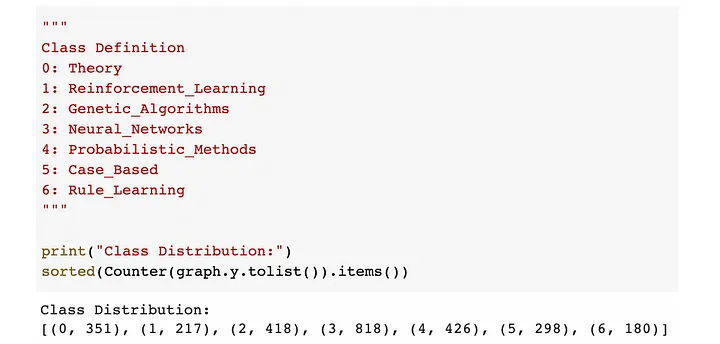

In [12]:
graph.y

tensor([3, 4, 4,  ..., 3, 3, 3])

In [13]:


# Get the train, validation, and test indices
idx_train = dataset[0].train_mask.nonzero().view(-1)
idx_val = dataset[0].val_mask.nonzero().view(-1)
idx_test = dataset[0].test_mask.nonzero().view(-1)

# Print some dataset statistics
print(f"Number of nodes: {adj.size(0)}")
print(f"Number of edges: {adj.sum().item() // 2}")  # Divide by 2 because the graph is undirected
print(f"Number of features per node: {features.size(1)}")
print(f"Number of classes: {int(labels.max()) + 1}")
print(f"Number of training nodes: {len(idx_train)}")
print(f"Number of validation nodes: {len(idx_val)}")
print(f"Number of test nodes: {len(idx_test)}")

Number of nodes: 10556
Number of edges: 13820218
Number of features per node: 1433
Number of classes: 7
Number of training nodes: 140
Number of validation nodes: 500
Number of test nodes: 1000


In [14]:
#combining for test, the test and validation:
import numpy as np
idx_unlabeled = np.union1d(idx_val, idx_test)
idx_unlabeled[:10]

array([140, 141, 142, 143, 144, 145, 146, 147, 148, 149])

In [15]:
#generate target nodes:
import random
target_number = 10
node_list = random.sample(list(idx_unlabeled),target_number)
node_list

[1714, 2623, 2435, 1867, 595, 254, 170, 484, 2401, 470]

In [16]:
torch.manual_seed(0)

if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    device = torch.device('cuda')
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [17]:
device

device(type='cuda')

###all nodes degree info

In [18]:
degree_cora = {}
for (u, v) in adj:
    if int(u) in degree_cora:
        degree_cora[int(u)] += 1
    else:
        degree_cora[int(u)] = 1

degree_cora

{0: 3,
 1: 3,
 2: 5,
 3: 1,
 4: 5,
 5: 3,
 6: 4,
 7: 1,
 8: 3,
 9: 2,
 10: 2,
 11: 2,
 12: 4,
 13: 2,
 14: 5,
 15: 4,
 16: 4,
 17: 5,
 18: 5,
 19: 1,
 20: 5,
 21: 2,
 22: 5,
 23: 1,
 24: 7,
 25: 4,
 26: 5,
 27: 4,
 28: 1,
 29: 2,
 30: 6,
 31: 1,
 32: 4,
 33: 9,
 34: 1,
 35: 3,
 36: 8,
 37: 3,
 38: 4,
 39: 7,
 40: 3,
 41: 4,
 42: 2,
 43: 6,
 44: 3,
 45: 6,
 46: 2,
 47: 2,
 48: 9,
 49: 2,
 50: 1,
 51: 6,
 52: 5,
 53: 3,
 54: 2,
 55: 12,
 56: 4,
 57: 1,
 58: 1,
 59: 10,
 60: 3,
 61: 5,
 62: 1,
 63: 1,
 64: 3,
 65: 10,
 66: 1,
 67: 3,
 68: 3,
 69: 7,
 70: 2,
 71: 3,
 72: 2,
 73: 12,
 74: 9,
 75: 6,
 76: 3,
 77: 2,
 78: 3,
 79: 2,
 80: 3,
 81: 4,
 82: 2,
 83: 2,
 84: 5,
 85: 3,
 86: 4,
 87: 3,
 88: 36,
 89: 10,
 90: 4,
 91: 6,
 92: 2,
 93: 4,
 94: 11,
 95: 21,
 96: 1,
 97: 2,
 98: 1,
 99: 6,
 100: 2,
 101: 3,
 102: 8,
 103: 6,
 104: 4,
 105: 4,
 106: 1,
 107: 4,
 108: 3,
 109: 32,
 110: 5,
 111: 6,
 112: 4,
 113: 3,
 114: 3,
 115: 1,
 116: 2,
 117: 2,
 118: 19,
 119: 6,
 120: 5,
 121: 7,
 1

#GCN

In [19]:
from torch_geometric.nn import GCNConv
from torch.nn import Linear, BatchNorm1d

class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.bn1 = BatchNorm1d(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.bn2 = BatchNorm1d(hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.bn3 = BatchNorm1d(hidden_channels)
        self.conv4 = GCNConv(hidden_channels, hidden_channels)
        self.bn4 = BatchNorm1d(hidden_channels)
        self.out = Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        # First Message Passing Layer (Transformation)
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        # Second Message Passing Layer
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        # Third Message Passing Layer
        x = self.conv3(x, edge_index)
        x = self.bn3(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        # Fourth Message Passing Layer
        x = self.conv4(x, edge_index)
        x = self.bn4(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        # Output layer
        x = self.out(x)
        x = F.softmax(x, dim=1)
        return x



In [20]:
graph.edge_index.shape

torch.Size([2, 10556])

Epoch 500/5000:
Train Loss: 1.1655, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000
Validation Loss: 1.5386, Validation Accuracy: 0.6380, Validation Precision: 0.6380, Validation Recall: 0.6380
Test Loss: 1.5096, Test Accuracy: 0.6700, Test Precision: 0.6700, Test Recall: 0.6700

Epoch 1000/5000:
Train Loss: 1.1655, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000
Validation Loss: 1.5571, Validation Accuracy: 0.6420, Validation Precision: 0.6420, Validation Recall: 0.6420
Test Loss: 1.5076, Test Accuracy: 0.6590, Test Precision: 0.6590, Test Recall: 0.6590

Epoch 1500/5000:
Train Loss: 1.1672, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000
Validation Loss: 1.4757, Validation Accuracy: 0.6760, Validation Precision: 0.6760, Validation Recall: 0.6760
Test Loss: 1.4642, Test Accuracy: 0.7160, Test Precision: 0.7160, Test Recall: 0.7160

Epoch 2000/5000:
Train Loss: 1.1655, Train Accuracy: 1.0000, Train Precision: 1.0000, Tra

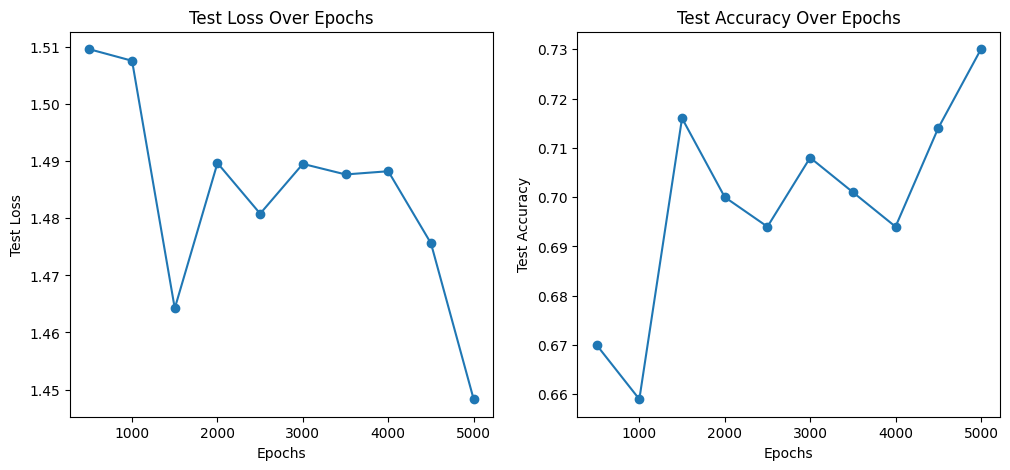

In [21]:
import torch
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt

# Initialize the model and optimizer
num_features = features.size(1)
num_classes = int(labels.max()) + 1
hidden_channels = 64  # You can adjust this as needed
model = GCN(num_features, hidden_channels, num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Define a function for evaluation
def evaluate(model, features,adj,labels, mask):
    model.eval()
    with torch.no_grad():
        logits = model(features, adj.t())
        logits = logits[mask]
        labels = labels[mask]
        pred = logits.max(1)[1]
        accuracy = accuracy_score(labels, pred)
        precision = precision_score(labels, pred, average='micro')
        recall = recall_score(labels, pred, average='micro')
        return accuracy, precision, recall

# Training loop
num_epochs = 5000
train_losses = []
val_losses = []
test_losses = []
train_accuracies = []
val_accuracies = []
test_accuracies = []

for epoch in range(1, num_epochs + 1):
    model.train()
    optimizer.zero_grad()
    logits = model(features, adj.t())
    loss = F.cross_entropy(logits[idx_train], labels[idx_train])
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        train_loss = loss.item()
        val_loss = F.cross_entropy(logits[idx_val], labels[idx_val]).item()
        test_loss = F.cross_entropy(logits[idx_test], labels[idx_test]).item()

        train_accuracy, train_precision, train_recall = evaluate(model, features,adj,labels, idx_train)
        val_accuracy, val_precision, val_recall = evaluate(model, features,adj,labels, idx_val)
        test_accuracy, test_precision, test_recall = evaluate(model, features,adj,labels, idx_test)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        test_losses.append(test_loss)

        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        test_accuracies.append(test_accuracy)

        print(f"Epoch {epoch}/{num_epochs}:")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}")
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Validation Precision: {val_precision:.4f}, Validation Recall: {val_recall:.4f}")
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}")
        print("")


# Plot test loss and accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(500, num_epochs + 1, 500), test_losses, marker='o')
plt.title('Test Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Test Loss')

plt.subplot(1, 2, 2)
plt.plot(range(500, num_epochs + 1, 500), test_accuracies, marker='o')
plt.title('Test Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.show()


In [22]:
#GCN

#calculate ricci

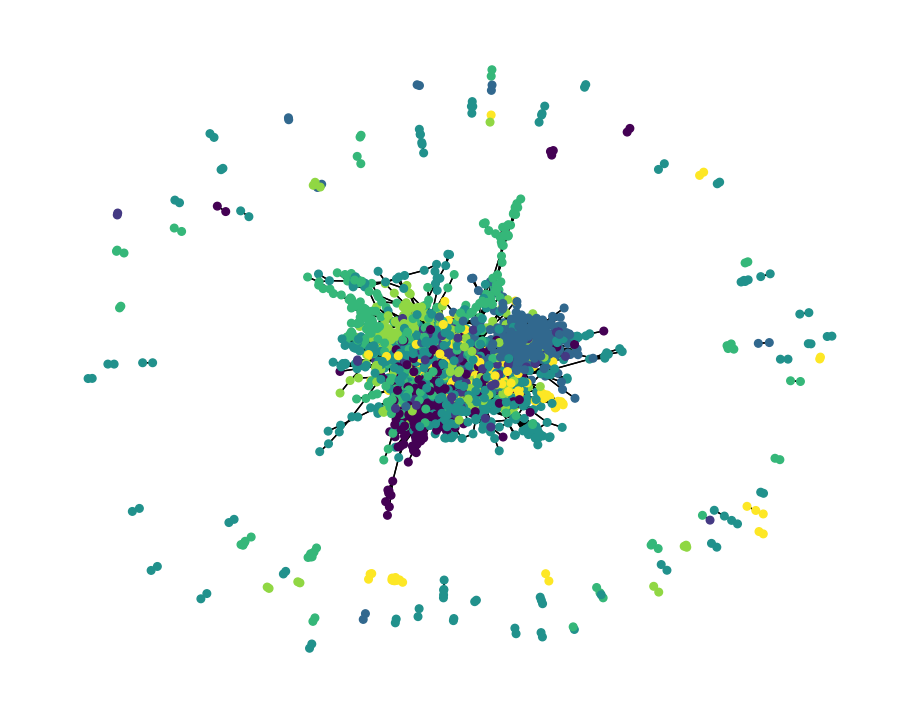

In [23]:
import random
from torch_geometric.utils import to_networkx
import networkx as nx

def convert_to_networkx(graph, n_sample=None):

    G = to_networkx(graph, node_attrs=["x"])
    y = graph.y.numpy()

    if n_sample is not None:
        sampled_nodes = random.sample(g.nodes, n_sample)
        G = G.subgraph(sampled_nodes)
        y = y[sampled_nodes]

    return G, y


def plot_graph(G, y):

    plt.figure(figsize=(9, 7))
    nx.draw_spring(G, node_size=30, arrows=False, node_color=y)
    plt.show()


G, y = convert_to_networkx(graph)
plot_graph(G, y)

In [24]:
# load GraphRicciCuravture package
from GraphRicciCurvature.OllivierRicci import OllivierRicci
orc = OllivierRicci(G, alpha=0.5, verbose="TRACE")

/usr/local/lib/python3.10/dist-packages/ot/backend.py:1368: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  jax.device_put(jnp.array(1, dtype=jnp.float64), d)
/usr/local/lib/python3.10/dist-packages/ot/backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())
INFO:GraphRicciCurvature:Edge weight not detected in graph, use "weight" as default edge weight.


In [25]:
orc.compute_ricci_curvature()
G_orc = orc.G.copy()  # save an intermediate result

TRACE:GraphRicciCurvature:Number of nodes: 2708
TRACE:GraphRicciCurvature:Number of edges: 10556
TRACE:GraphRicciCurvature:Start to compute all pair shortest path.
TRACE:GraphRicciCurvature:0.957597 secs for all pair by NetworKit.
INFO:GraphRicciCurvature:3.112266 secs for Ricci curvature computation.


Karate Club Graph, first 5 edges: 
Ollivier-Ricci curvature of edge (0,633) is 0.000000
Ollivier-Ricci curvature of edge (0,1862) is 0.250000
Ollivier-Ricci curvature of edge (0,2582) is 0.166667
Ollivier-Ricci curvature of edge (1,2) is -0.466667
Ollivier-Ricci curvature of edge (1,652) is -0.166667


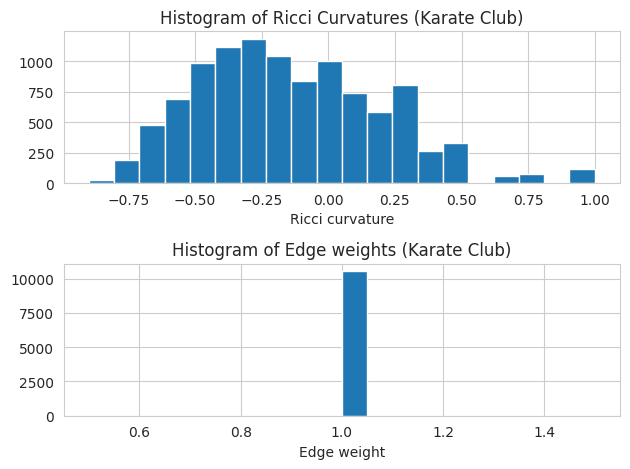

In [26]:
def show_results(G):
    # Print the first five results
    print("Karate Club Graph, first 5 edges: ")
    for n1,n2 in list(G.edges())[:5]:
        print("Ollivier-Ricci curvature of edge (%s,%s) is %f" % (n1 ,n2, G[n1][n2]["ricciCurvature"]))

    # Plot the histogram of Ricci curvatures
    plt.subplot(2, 1, 1)
    ricci_curvtures = nx.get_edge_attributes(G, "ricciCurvature").values()
    plt.hist(ricci_curvtures,bins=20)
    plt.xlabel('Ricci curvature')
    plt.title("Histogram of Ricci Curvatures (Karate Club)")

    # Plot the histogram of edge weights
    plt.subplot(2, 1, 2)
    weights = nx.get_edge_attributes(G, "weight").values()
    plt.hist(weights,bins=20)
    plt.xlabel('Edge weight')
    plt.title("Histogram of Edge weights (Karate Club)")

    plt.tight_layout()

show_results(G_orc)

##list of scores

In [27]:
def calculate_ricci_curvatures(G):
    ricci_curvature_values = []

    for u, v in G.edges():
        try:
            ricci_curvature = G[u][v]["ricciCurvature"]
            ricci_curvature_values.append(ricci_curvature)
        except KeyError:
            # Handle the case where "ricciCurvature" attribute is not set
            # You can choose to skip these edges or assign a default value
            ricci_curvature_values.append(0.0)  # Default value

    return ricci_curvature_values

# Calculate Ricci curvatures and store them in a list
ricci_curvatures = calculate_ricci_curvatures(G_orc)

# Now, the 'ricci_curvatures' list contains the Ollivier-Ricci curvature values for all edges
print(ricci_curvatures)


[1.1102230246251565e-16, 0.25, 0.16666666666666674, -0.46666666666666656, -0.16666666666666652, 0.33333333333333337, -0.46666666666666656, -0.40000000000000013, 0.20000000000000007, -0.55, -0.7615384615384595, 1.0, 0.09999999999999998, 0.33750000000000013, -0.17142857142857149, 0.4, 0.1875, 0.16666666666666663, 0.41666666666666674, -0.4166666666666665, 1.1102230246251565e-16, -0.17391304347826075, -0.2916666666666665, -0.19999999999999996, 1.0, -0.3666666666666667, -0.4166666666666665, -0.46666666666666656, 0.75, 0.1499999999999999, -0.30000000000000004, 0.5, -0.0833333333333337, 0.08333333333333348, 0.375, 0.4583333333333335, 0.375, 0.45833333333333337, -0.42567567567567544, -0.3977272727272736, -0.09999999999999987, -0.6499999999999999, -0.050000000000000044, -0.06666666666666665, -0.10000000000000009, 0.3035714285714286, 0.41666666666666674, 0.44999999999999996, -0.01785714285714257, -0.24999999999999978, 0.08333333333333348, -0.45833333333333304, 0.0, -0.4142857142857139, 0.2666666

In [28]:
def calculate_ricci_curvatures_with_edges(G):
    ricci_curvature_values_with_edges = []

    for u, v in G.edges():
        try:
            ricci_curvature = G[u][v]["ricciCurvature"]
            ricci_curvature_values_with_edges.append(((u, v), ricci_curvature))
        except KeyError:
            # Handle the case where "ricciCurvature" attribute is not set
            # You can choose to skip these edges or assign a default value
            ricci_curvature_values_with_edges.append(((u, v), 0.0))  # Default value

    return ricci_curvature_values_with_edges

# Calculate Ricci curvatures with edge information and store them in a list of tuples
ricci_curvatures_with_edges = calculate_ricci_curvatures_with_edges(G_orc)

# Now, the 'ricci_curvatures_with_edges' list contains tuples, each containing the edge and its Ricci curvature value
for edge, curvature in ricci_curvatures_with_edges:
    print(f"Edge {edge} - Ollivier-Ricci curvature: {curvature}")


Streaming output truncated to the last 5000 lines.
Edge (1399, 2227) - Ollivier-Ricci curvature: -0.46666666666666656
Edge (1399, 2309) - Ollivier-Ricci curvature: -0.6749999999999998
Edge (1399, 2394) - Ollivier-Ricci curvature: -0.38749999999999973
Edge (1400, 886) - Ollivier-Ricci curvature: 0.0
Edge (1400, 2698) - Ollivier-Ricci curvature: 0.0
Edge (1401, 89) - Ollivier-Ricci curvature: -0.2000000000000004
Edge (1401, 258) - Ollivier-Ricci curvature: 1.1102230246251565e-16
Edge (1401, 761) - Ollivier-Ricci curvature: -0.09999999999999987
Edge (1401, 1153) - Ollivier-Ricci curvature: 0.2500000000000001
Edge (1401, 1585) - Ollivier-Ricci curvature: 1.1102230246251565e-16
Edge (1402, 1163) - Ollivier-Ricci curvature: -0.10000000000000009
Edge (1402, 1482) - Ollivier-Ricci curvature: -0.30000000000000027
Edge (1402, 1616) - Ollivier-Ricci curvature: -0.6333333333333335
Edge (1402, 1919) - Ollivier-Ricci curvature: -0.4666666666666668
Edge (1402, 1972) - Ollivier-Ricci curvature: -0.466

In [29]:
# Assuming you have a list of tuples called 'ricci_curvatures_with_edges'
# Each tuple contains the edge and its corresponding Ricci curvature value

positive_curvatures_with_edges = []
negative_curvatures_with_edges = []
zero_curvatures_with_edges = []

for edge, curvature in ricci_curvatures_with_edges:
    if curvature > 0:
        positive_curvatures_with_edges.append((edge, curvature))
    elif curvature < 0:
        negative_curvatures_with_edges.append((edge, curvature))
    else:
        zero_curvatures_with_edges.append((edge, curvature))

# Now you have three separate lists:
# positive_curvatures_with_edges, negative_curvatures_with_edges, and zero_curvatures_with_edges


In [31]:
positive_curvatures_with_edges


[((0, 633), 1.1102230246251565e-16),
 ((0, 1862), 0.25),
 ((0, 2582), 0.16666666666666674),
 ((1, 654), 0.33333333333333337),
 ((2, 1454), 0.20000000000000007),
 ((3, 2544), 1.0),
 ((4, 1016), 0.09999999999999998),
 ((4, 1256), 0.33750000000000013),
 ((4, 2175), 0.4),
 ((4, 2176), 0.1875),
 ((5, 1629), 0.16666666666666663),
 ((5, 1659), 0.41666666666666674),
 ((6, 373), 1.1102230246251565e-16),
 ((7, 208), 1.0),
 ((9, 723), 0.75),
 ((9, 2614), 0.1499999999999999),
 ((10, 2545), 0.5),
 ((11, 1839), 0.08333333333333348),
 ((12, 1001), 0.375),
 ((12, 1318), 0.4583333333333335),
 ((12, 2661), 0.375),
 ((12, 2662), 0.45833333333333337),
 ((15, 1090), 0.3035714285714286),
 ((15, 1093), 0.41666666666666674),
 ((15, 1271), 0.44999999999999996),
 ((16, 1632), 0.08333333333333348),
 ((17, 927), 0.26666666666666683),
 ((17, 1315), 0.15000000000000002),
 ((17, 1316), 0.19999999999999996),
 ((17, 2140), 0.30000000000000004),
 ((19, 1939), 0.5),
 ((20, 2374), 0.20000000000000007),
 ((22, 1234), 0.20

In [32]:
len(positive_curvatures_with_edges)

3442

In [34]:
negative_curvatures_with_edges

[((1, 2), -0.46666666666666656),
 ((1, 652), -0.16666666666666652),
 ((2, 1), -0.46666666666666656),
 ((2, 332), -0.40000000000000013),
 ((2, 1666), -0.55),
 ((2, 1986), -0.7615384615384595),
 ((4, 1761), -0.17142857142857149),
 ((5, 2546), -0.4166666666666665),
 ((6, 1042), -0.17391304347826075),
 ((6, 1416), -0.2916666666666665),
 ((6, 1602), -0.19999999999999996),
 ((8, 269), -0.3666666666666667),
 ((8, 281), -0.4166666666666665),
 ((8, 1996), -0.46666666666666656),
 ((10, 476), -0.30000000000000004),
 ((11, 1655), -0.0833333333333337),
 ((13, 1701), -0.42567567567567544),
 ((13, 1810), -0.3977272727272736),
 ((14, 158), -0.09999999999999987),
 ((14, 2034), -0.6499999999999999),
 ((14, 2075), -0.050000000000000044),
 ((14, 2077), -0.06666666666666665),
 ((14, 2668), -0.10000000000000009),
 ((15, 2367), -0.01785714285714257),
 ((16, 970), -0.24999999999999978),
 ((16, 2444), -0.45833333333333304),
 ((17, 24), -0.4142857142857139),
 ((18, 139), -0.3875000000000002),
 ((18, 1560), -0.1

In [35]:
len(negative_curvatures_with_edges)

6817

In [36]:
zero_curvatures_with_edges

[((16, 2642), 0.0),
 ((21, 1043), 0.0),
 ((21, 2310), 0.0),
 ((32, 518), 0.0),
 ((36, 2106), 0.0),
 ((36, 2107), 0.0),
 ((42, 1372), 0.0),
 ((78, 1219), 0.0),
 ((78, 1329), 0.0),
 ((80, 2049), 0.0),
 ((83, 2581), 0.0),
 ((89, 1653), 0.0),
 ((101, 1589), 0.0),
 ((102, 2256), 0.0),
 ((130, 1982), 0.0),
 ((140, 582), 0.0),
 ((140, 623), 0.0),
 ((152, 884), 0.0),
 ((167, 168), 0.0),
 ((167, 2437), 0.0),
 ((169, 1994), 0.0),
 ((183, 1837), 0.0),
 ((194, 2564), 0.0),
 ((195, 2424), 0.0),
 ((234, 2591), 0.0),
 ((245, 1162), 0.0),
 ((261, 873), 0.0),
 ((283, 2250), 0.0),
 ((311, 343), 0.0),
 ((312, 1722), 0.0),
 ((320, 1597), 0.0),
 ((321, 1083), 0.0),
 ((328, 951), 0.0),
 ((342, 1512), 0.0),
 ((343, 311), 0.0),
 ((365, 2469), 0.0),
 ((376, 672), 0.0),
 ((389, 2450), 0.0),
 ((396, 1217), 0.0),
 ((396, 1988), 0.0),
 ((405, 1275), 0.0),
 ((407, 695), 0.0),
 ((411, 2609), 0.0),
 ((432, 1442), 0.0),
 ((432, 1597), 0.0),
 ((434, 1693), 0.0),
 ((442, 588), 0.0),
 ((443, 1531), 0.0),
 ((445, 1434), 0

In [37]:
len(zero_curvatures_with_edges)

297

In [38]:
3442+6817+297

10556

###following code exclude symmstry adjecency

In [30]:
#following code exclude symmstry adjecency

In [71]:
# Assuming you have a list of tuples called 'ricci_curvatures_with_edges'
# Each tuple contains the edge and its corresponding Ricci curvature value

positive_curvatures_with_edges = []
negative_curvatures_with_edges = []
zero_curvatures_with_edges = []

visited_edges = set()  # To keep track of visited edges

for edge, curvature in ricci_curvatures_with_edges:
    # Sort the nodes in the edge tuple to have a consistent order
    sorted_edge = tuple(sorted(edge))

    # Check if the sorted edge or its reverse has been visited
    if sorted_edge not in visited_edges and sorted_edge[::-1] not in visited_edges:
        visited_edges.add(sorted_edge)  # Add the sorted edge to the visited set

        if curvature > 0:
            positive_curvatures_with_edges.append((sorted_edge, curvature))
        elif curvature < 0:
            negative_curvatures_with_edges.append((sorted_edge, curvature))
        else:
            zero_curvatures_with_edges.append((sorted_edge, curvature))

# Now you have three separate lists:
# positive_curvatures_with_edges, negative_curvatures_with_edges, and zero_curvatures_with_edges


In [76]:
len(positive_curvatures_with_edges)

1721

In [77]:
len(negative_curvatures_with_edges)

3408

In [78]:
1721+3408+149

5278

In [79]:
5278*2

10556

In [72]:

positive_curvatures_with_edges

[((0, 633), 1.1102230246251565e-16),
 ((0, 1862), 0.25),
 ((0, 2582), 0.16666666666666674),
 ((1, 654), 0.33333333333333337),
 ((2, 1454), 0.20000000000000007),
 ((3, 2544), 1.0),
 ((4, 1016), 0.09999999999999998),
 ((4, 1256), 0.33750000000000013),
 ((4, 2175), 0.4),
 ((4, 2176), 0.1875),
 ((5, 1629), 0.16666666666666663),
 ((5, 1659), 0.41666666666666674),
 ((6, 373), 1.1102230246251565e-16),
 ((7, 208), 1.0),
 ((9, 723), 0.75),
 ((9, 2614), 0.1499999999999999),
 ((10, 2545), 0.5),
 ((11, 1839), 0.08333333333333348),
 ((12, 1001), 0.375),
 ((12, 1318), 0.4583333333333335),
 ((12, 2661), 0.375),
 ((12, 2662), 0.45833333333333337),
 ((15, 1090), 0.3035714285714286),
 ((15, 1093), 0.41666666666666674),
 ((15, 1271), 0.44999999999999996),
 ((16, 1632), 0.08333333333333348),
 ((17, 927), 0.26666666666666683),
 ((17, 1315), 0.15000000000000002),
 ((17, 1316), 0.19999999999999996),
 ((17, 2140), 0.30000000000000004),
 ((19, 1939), 0.5),
 ((20, 2374), 0.20000000000000007),
 ((22, 1234), 0.20

In [73]:

negative_curvatures_with_edges

[((1, 2), -0.46666666666666656),
 ((1, 652), -0.16666666666666652),
 ((2, 332), -0.40000000000000013),
 ((2, 1666), -0.55),
 ((2, 1986), -0.7615384615384595),
 ((4, 1761), -0.17142857142857149),
 ((5, 2546), -0.4166666666666665),
 ((6, 1042), -0.17391304347826075),
 ((6, 1416), -0.2916666666666665),
 ((6, 1602), -0.19999999999999996),
 ((8, 269), -0.3666666666666667),
 ((8, 281), -0.4166666666666665),
 ((8, 1996), -0.46666666666666656),
 ((10, 476), -0.30000000000000004),
 ((11, 1655), -0.0833333333333337),
 ((13, 1701), -0.42567567567567544),
 ((13, 1810), -0.3977272727272736),
 ((14, 158), -0.09999999999999987),
 ((14, 2034), -0.6499999999999999),
 ((14, 2075), -0.050000000000000044),
 ((14, 2077), -0.06666666666666665),
 ((14, 2668), -0.10000000000000009),
 ((15, 2367), -0.01785714285714257),
 ((16, 970), -0.24999999999999978),
 ((16, 2444), -0.45833333333333304),
 ((17, 24), -0.4142857142857139),
 ((18, 139), -0.3875000000000002),
 ((18, 1560), -0.19999999999999996),
 ((18, 1786), 

In [80]:
# Find the edge with the most negative curvature value
most_negative_edge, most_negative_curvature = min(negative_curvatures_with_edges, key=lambda x: x[1])

print("Edge with the most negative curvature:", most_negative_edge)
print("Most negative curvature value:", most_negative_curvature)

Edge with the most negative curvature: (645, 1358)
Most negative curvature value: -0.898809523809518


In [74]:

zero_curvatures_with_edges

[((16, 2642), 0.0),
 ((21, 1043), 0.0),
 ((21, 2310), 0.0),
 ((32, 518), 0.0),
 ((36, 2106), 0.0),
 ((36, 2107), 0.0),
 ((42, 1372), 0.0),
 ((78, 1219), 0.0),
 ((78, 1329), 0.0),
 ((80, 2049), 0.0),
 ((83, 2581), 0.0),
 ((89, 1653), 0.0),
 ((101, 1589), 0.0),
 ((102, 2256), 0.0),
 ((130, 1982), 0.0),
 ((140, 582), 0.0),
 ((140, 623), 0.0),
 ((152, 884), 0.0),
 ((167, 168), 0.0),
 ((167, 2437), 0.0),
 ((169, 1994), 0.0),
 ((183, 1837), 0.0),
 ((194, 2564), 0.0),
 ((195, 2424), 0.0),
 ((234, 2591), 0.0),
 ((245, 1162), 0.0),
 ((261, 873), 0.0),
 ((283, 2250), 0.0),
 ((311, 343), 0.0),
 ((312, 1722), 0.0),
 ((320, 1597), 0.0),
 ((321, 1083), 0.0),
 ((328, 951), 0.0),
 ((342, 1512), 0.0),
 ((365, 2469), 0.0),
 ((376, 672), 0.0),
 ((389, 2450), 0.0),
 ((396, 1217), 0.0),
 ((396, 1988), 0.0),
 ((405, 1275), 0.0),
 ((407, 695), 0.0),
 ((411, 2609), 0.0),
 ((432, 1442), 0.0),
 ((432, 1597), 0.0),
 ((434, 1693), 0.0),
 ((442, 588), 0.0),
 ((443, 1531), 0.0),
 ((445, 1434), 0.0),
 ((446, 1507), 

In [75]:
len(zero_curvatures_with_edges )

149

##now  do all zero_curvature_values negative randomly

In [39]:
import random

# Assuming you have a list of tuples called 'zero_curvatures_with_edges'
# Each tuple contains the edge and its corresponding zero Ricci curvature value

# Define the range for random negative curvature values
min_negative_curvature = -2.0
max_negative_curvature = -0.1

# Iterate through the zero_curvatures_with_edges list and assign random negative curvatures
for i, (edge, _) in enumerate(zero_curvatures_with_edges):
    random_curvature = random.uniform(min_negative_curvature, max_negative_curvature)
    zero_curvatures_with_edges[i] = (edge, random_curvature)

# Now, zero_curvatures_with_edges contains random negative curvatures for previously zero curvatures


In [40]:
zero_curvatures_with_edges

[((16, 2642), -1.395817051736497),
 ((21, 1043), -1.485527519214571),
 ((21, 2310), -1.8024405153475729),
 ((32, 518), -1.9865081596792984),
 ((36, 2106), -1.8005148285609998),
 ((36, 2107), -0.14357802868562253),
 ((42, 1372), -0.9409847435236243),
 ((78, 1219), -1.1297656801689988),
 ((78, 1329), -1.9779778712789757),
 ((80, 2049), -0.4899939047190658),
 ((83, 2581), -1.3435680619313692),
 ((89, 1653), -1.0263512232448662),
 ((101, 1589), -0.6891508266535638),
 ((102, 2256), -1.9739582526747563),
 ((130, 1982), -0.655568457796502),
 ((140, 582), -1.0854070765084143),
 ((140, 623), -0.8286978485385694),
 ((152, 884), -1.443910111201773),
 ((167, 168), -1.9735215576082514),
 ((167, 2437), -0.26097609349616846),
 ((169, 1994), -1.683240429074575),
 ((183, 1837), -1.9859274395832902),
 ((194, 2564), -1.3548531806574218),
 ((195, 2424), -1.5459750301600133),
 ((234, 2591), -1.7776717213795967),
 ((245, 1162), -0.7641025097147511),
 ((261, 873), -0.7782606668524095),
 ((283, 2250), -0.1486

In [41]:
len(zero_curvatures_with_edges)

297

In [42]:
modified_zero_curvatures_with_edges = zero_curvatures_with_edges.copy()

In [43]:
modified_zero_curvatures_with_edges

[((16, 2642), -1.395817051736497),
 ((21, 1043), -1.485527519214571),
 ((21, 2310), -1.8024405153475729),
 ((32, 518), -1.9865081596792984),
 ((36, 2106), -1.8005148285609998),
 ((36, 2107), -0.14357802868562253),
 ((42, 1372), -0.9409847435236243),
 ((78, 1219), -1.1297656801689988),
 ((78, 1329), -1.9779778712789757),
 ((80, 2049), -0.4899939047190658),
 ((83, 2581), -1.3435680619313692),
 ((89, 1653), -1.0263512232448662),
 ((101, 1589), -0.6891508266535638),
 ((102, 2256), -1.9739582526747563),
 ((130, 1982), -0.655568457796502),
 ((140, 582), -1.0854070765084143),
 ((140, 623), -0.8286978485385694),
 ((152, 884), -1.443910111201773),
 ((167, 168), -1.9735215576082514),
 ((167, 2437), -0.26097609349616846),
 ((169, 1994), -1.683240429074575),
 ((183, 1837), -1.9859274395832902),
 ((194, 2564), -1.3548531806574218),
 ((195, 2424), -1.5459750301600133),
 ((234, 2591), -1.7776717213795967),
 ((245, 1162), -0.7641025097147511),
 ((261, 873), -0.7782606668524095),
 ((283, 2250), -0.1486

In [44]:
len(modified_zero_curvatures_with_edges)

297

#modify the original graph

In [45]:
# Iterate through the list of tuples and update the edge attributes in the original graph
for (u, v), negative_curvature in modified_zero_curvatures_with_edges:
    # Update the "ricciCurvature" attribute for the edge (u, v) in your original graph
    G_orc[u][v]["ricciCurvature"] = negative_curvature

# Now, your original graph 'G_orc' has been updated with the negative curvature values


In [46]:
G_orc

##convert networkX to ptorch object to work with GNN

In [49]:
import torch
import torch_geometric.data as data

# Extract nodes and edges
nodes = list(G_orc.nodes())
edges = list(G_orc.edges())

# Convert nodes to a list of integers
nodes = [int(node) for node in nodes]

# Create a PyTorch tensor for node features
node_features = torch.zeros(len(nodes), num_features)  # Replace 'num_features' with the actual number of features per node

# Create a PyTorch tensor for the edge indices
edge_index = torch.tensor(edges).t().contiguous()

# Create a PyTorch tensor for node labels (if applicable)
node_labels = torch.tensor([G_orc.nodes[node]["label"] for node in nodes])

# Create train, validation, and test masks (if applicable)
train_mask = torch.zeros(len(nodes), dtype=torch.uint8)
val_mask = torch.zeros(len(nodes), dtype=torch.uint8)
test_mask = torch.zeros(len(nodes), dtype=torch.uint8)

# Replace the appropriate entries in train, validation, and test masks based on your data split
# For example, if nodes 0 to 499 are in the training set:
train_mask[:500] = 1
# Repeat this for validation and test sets

# Create a PyTorch Geometric 'Data' object
data_obj = data.Data(
    x=node_features,
    edge_index=edge_index,
    y=node_labels,
    train_mask=train_mask,
    val_mask=val_mask,
    test_mask=test_mask
)

# Now, 'data_obj' is a PyTorch Geometric Data object that you can use with GNNs.



KeyError: ignored

In [74]:
# Extract nodes and edges
nodes = list(G_orc.nodes())
edges = list(G_orc.edges())

# Convert nodes to a list of integers
nodes = [int(node) for node in nodes]

# Create a PyTorch tensor for node features (assuming num_features is known)
num_features = 1433  # Replace with the actual number of features per node
node_features = torch.zeros(len(nodes), num_features)

# Create a PyTorch tensor for the edge indices
edge_index = torch.tensor(edges).t().contiguous()

# Create train, validation, and test masks
train_mask = torch.zeros(len(nodes), dtype=torch.uint8)
val_mask = torch.zeros(len(nodes), dtype=torch.uint8)
test_mask = torch.zeros(len(nodes), dtype=torch.uint8)

# Set the desired numbers of nodes for each split (adjust as needed)
num_train_nodes = 140
num_val_nodes = 500
num_test_nodes = 1000

# Randomly select nodes for training, validation, and test sets
all_indices = list(range(len(nodes)))
torch.manual_seed(42)  # For reproducibility, you can change the seed
train_indices = torch.tensor(all_indices[:num_train_nodes])
val_indices = torch.tensor(all_indices[num_train_nodes:num_train_nodes + num_val_nodes])
test_indices = torch.tensor(all_indices[num_train_nodes + num_val_nodes:])

# Update the train, validation, and test masks based on the selected indices
train_mask[train_indices] = 1
val_mask[val_indices] = 1
test_mask[test_indices] = 1

# Create a PyTorch Geometric 'Data' object
data_obj = data.Data(
    x=node_features,
    edge_index=edge_index,
    train_mask=train_mask,
    val_mask=val_mask,
    test_mask=test_mask
)


In [75]:
data_obj

Data(x=[2708, 1433], edge_index=[2, 10556], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [76]:
data_obj.y = graph.y


In [77]:
data_obj

Data(x=[2708, 1433], edge_index=[2, 10556], train_mask=[2708], val_mask=[2708], test_mask=[2708], y=[2708])

#GCN with modified graph

##visualize modified graph

In [78]:
data_obj

Data(x=[2708, 1433], edge_index=[2, 10556], train_mask=[2708], val_mask=[2708], test_mask=[2708], y=[2708])

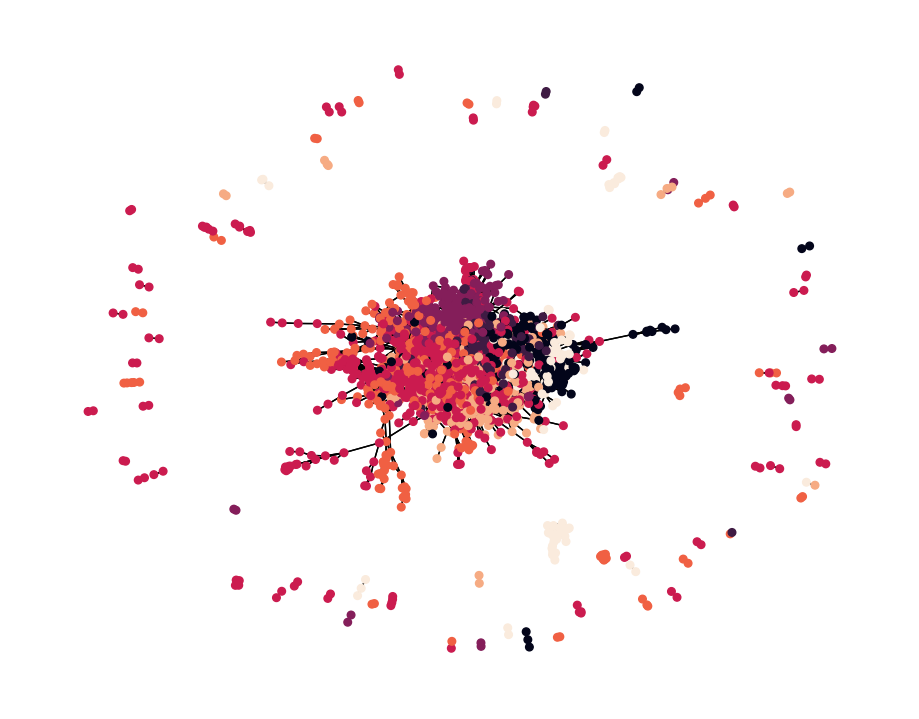

In [79]:
import random
from torch_geometric.utils import to_networkx
import networkx as nx

def convert_to_networkx(data_obj, n_sample=None):

    G = to_networkx(data_obj, node_attrs=["x"])
    y = data_obj.y.numpy()

    if n_sample is not None:
        sampled_nodes = random.sample(g.nodes, n_sample)
        G = G.subgraph(sampled_nodes)
        y = y[sampled_nodes]

    return G, y


def plot_graph(G, y):

    plt.figure(figsize=(9, 7))
    nx.draw_spring(G, node_size=30, arrows=False, node_color=y)
    plt.show()


G, y = convert_to_networkx(data_obj)
plot_graph(G, y)

In [80]:
data_obj.x

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [81]:
data_obj

Data(x=[2708, 1433], edge_index=[2, 10556], train_mask=[2708], val_mask=[2708], test_mask=[2708], y=[2708])

In [82]:
data_obj.edge_index.T #connected node pairs

tensor([[   0,  633],
        [   0, 1862],
        [   0, 2582],
        ...,
        [2707,  598],
        [2707, 1473],
        [2707, 2706]])

In [83]:
adj = data_obj.edge_index.t() ## Get the adjacency matrix,
adj

tensor([[   0,  633],
        [   0, 1862],
        [   0, 2582],
        ...,
        [2707,  598],
        [2707, 1473],
        [2707, 2706]])

In [84]:
data_obj.edge_index

tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
        [ 633, 1862, 2582,  ...,  598, 1473, 2706]])

In [85]:
features = data_obj.x
print(features)
labels = data_obj.y
print(labels)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([3, 4, 4,  ..., 3, 3, 3])


In [86]:
data_obj.y

tensor([3, 4, 4,  ..., 3, 3, 3])

In [87]:


# Get the train, validation, and test indices
idx_train = data_obj.train_mask.nonzero().view(-1)
idx_val = data_obj.val_mask.nonzero().view(-1)
idx_test = data_obj.test_mask.nonzero().view(-1)

# Print some dataset statistics
print(f"Number of nodes: {adj.size(0)}")
print(f"Number of edges: {adj.sum().item() // 2}")  # Divide by 2 because the graph is undirected
print(f"Number of features per node: {features.size(1)}")
print(f"Number of classes: {int(labels.max()) + 1}")
print(f"Number of training nodes: {len(idx_train)}")
print(f"Number of validation nodes: {len(idx_val)}")
print(f"Number of test nodes: {len(idx_test)}")

Number of nodes: 10556
Number of edges: 13820218
Number of features per node: 1433
Number of classes: 7
Number of training nodes: 140
Number of validation nodes: 500
Number of test nodes: 2068


##apply GCN

Epoch 500/5000:
Train Loss: 1.9459, Train Accuracy: 0.1429, Train Precision: 0.1429, Train Recall: 0.1429
Validation Loss: 1.9459, Validation Accuracy: 0.1560, Validation Precision: 0.1560, Validation Recall: 0.1560
Test Loss: 1.9459, Test Accuracy: 0.1547, Test Precision: 0.1547, Test Recall: 0.1547

Epoch 1000/5000:
Train Loss: 1.9459, Train Accuracy: 0.1429, Train Precision: 0.1429, Train Recall: 0.1429
Validation Loss: 1.9459, Validation Accuracy: 0.0720, Validation Precision: 0.0720, Validation Recall: 0.0720
Test Loss: 1.9459, Test Accuracy: 0.0779, Test Precision: 0.0779, Test Recall: 0.0779

Epoch 1500/5000:
Train Loss: 1.9459, Train Accuracy: 0.1429, Train Precision: 0.1429, Train Recall: 0.1429
Validation Loss: 1.9459, Validation Accuracy: 0.3160, Validation Precision: 0.3160, Validation Recall: 0.3160
Test Loss: 1.9459, Test Accuracy: 0.3095, Test Precision: 0.3095, Test Recall: 0.3095

Epoch 2000/5000:
Train Loss: 1.9459, Train Accuracy: 0.1429, Train Precision: 0.1429, Tra

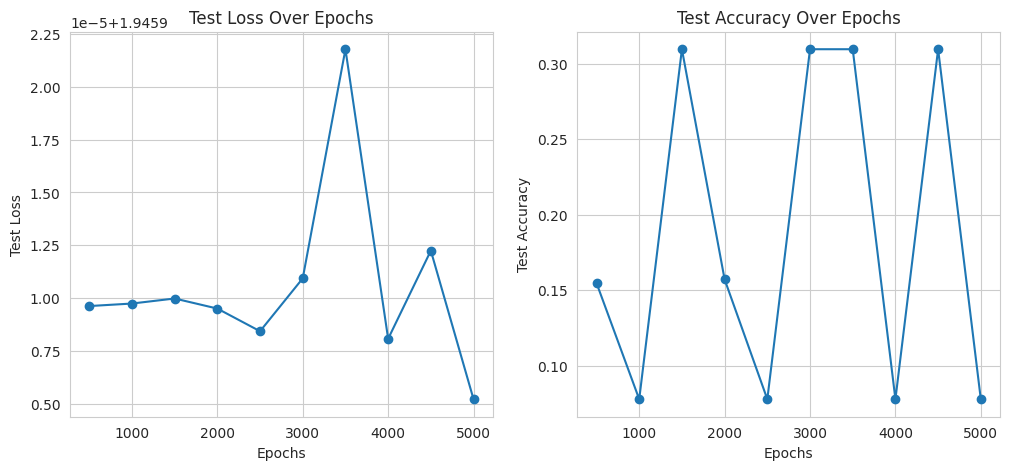

In [88]:
import torch
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
#graph
# Initialize the model and optimizer
num_features = features.size(1)
num_classes = int(labels.max()) + 1
hidden_channels = 64  # You can adjust this as needed
model = GCN(num_features, hidden_channels, num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Define a function for evaluation
def evaluate(model, features,adj,labels, mask):
    model.eval()
    with torch.no_grad():
        logits = model(features, adj.t())
        logits = logits[mask]
        labels = labels[mask]
        pred = logits.max(1)[1]
        accuracy = accuracy_score(labels, pred)
        precision = precision_score(labels, pred, average='micro')
        recall = recall_score(labels, pred, average='micro')
        return accuracy, precision, recall

# Training loop
num_epochs = 5000
train_losses = []
val_losses = []
test_losses = []
train_accuracies = []
val_accuracies = []
test_accuracies = []

for epoch in range(1, num_epochs + 1):
    model.train()
    optimizer.zero_grad()
    logits = model(features, adj.t())
    loss = F.cross_entropy(logits[idx_train], labels[idx_train])
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        train_loss = loss.item()
        val_loss = F.cross_entropy(logits[idx_val], labels[idx_val]).item()
        test_loss = F.cross_entropy(logits[idx_test], labels[idx_test]).item()

        train_accuracy, train_precision, train_recall = evaluate(model, features,adj,labels, idx_train)
        val_accuracy, val_precision, val_recall = evaluate(model, features,adj,labels, idx_val)
        test_accuracy, test_precision, test_recall = evaluate(model, features,adj,labels, idx_test)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        test_losses.append(test_loss)

        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        test_accuracies.append(test_accuracy)

        print(f"Epoch {epoch}/{num_epochs}:")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}")
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Validation Precision: {val_precision:.4f}, Validation Recall: {val_recall:.4f}")
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}")
        print("")


# Plot test loss and accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(500, num_epochs + 1, 500), test_losses, marker='o')
plt.title('Test Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Test Loss')

plt.subplot(1, 2, 2)
plt.plot(range(500, num_epochs + 1, 500), test_accuracies, marker='o')
plt.title('Test Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.show()


In [ ]:
#Test Accuracy: 0.7300 with original graph

In [ ]:
#Test Accuracy: 0.0779

#gurbage

In [27]:
# # colab setting
!pip install GraphRicciCurvature
!pip install scikit-learn

import networkx as nx
import numpy as np
import math
import importlib

# matplotlib setting
%matplotlib inline
import matplotlib.pyplot as plt

# to print logs in jupyter notebook
import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

# load GraphRicciCuravture package
from GraphRicciCurvature.OllivierRicci import OllivierRicci

# load python-louvain for modularity computation
import community as community_louvain

# for ARI computation
from sklearn import preprocessing, metrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 790.0/790.0 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 28.8 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/ot/backend.py:1368: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  jax.device_put(jnp.array(1, dtype=jnp.float64), d)
/usr/local/lib/python3.10/dist-packages/ot/backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())


In [39]:
graph.x.shape[0]

2708

In [32]:
graph

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [47]:
import networkx as nx
import torch

# Assuming 'graph' is your PyTorch Geometric Data object
G = nx.Graph()

# Add nodes and node attributes
for i in range(graph.num_nodes):
    node_features = graph.x[i].tolist()  # Get node features
    label = graph.y[i].item()  # Get node label
    G.add_node(i, features=node_features, label=label)

# Add edges
edges = graph.edge_index.t().tolist()
G.add_edges_from(edges)

# Now, 'G' is a NetworkX graph representation of your Cora dataset


In [52]:
# Assuming you have your Cora dataset loaded as G and imported GraphRicciCurvature

# Create an instance of OllivierRicci
orc = OllivierRicci(g, alpha=0.5, verbose="TRACE")

# Compute Ricci curvature
orc.compute_ricci_curvature()

# Access Ricci curvature values for each edge
for u, v in g.edges():
    ricci_curvature = g[u][v]["ricciCurvature"]
    print(f"Edge ({u}, {v}) - Ollivier-Ricci curvature: {ricci_curvature}")


INFO:GraphRicciCurvature:Edge weight not detected in graph, use "weight" as default edge weight.
TRACE:GraphRicciCurvature:Number of nodes: 1000
TRACE:GraphRicciCurvature:Number of edges: 1574
TRACE:GraphRicciCurvature:Start to compute all pair shortest path.
TRACE:GraphRicciCurvature:0.223857 secs for all pair by NetworKit.
INFO:GraphRicciCurvature:1.040306 secs for Ricci curvature computation.


KeyError: ignored

In [46]:
# Compute Ollivier-Ricci curvature
orc.compute_ricci_curvature()

# Access curvature values for specific edges
edge_curvature_values = {}
for u, v in nx_graph.edges():
    edge_curvature_values[(u, v)] = nx_graph[u][v]["ricciCurvature"]

# Now 'edge_curvature_values' contains the Ollivier-Ricci curvature values for each edge in your graph

INFO:GraphRicciCurvature:3.365506 secs for Ricci curvature computation.


KeyError: ignored

In [ ]:
def show_results(nx_graph):
    # Print the first five results
    print("Karate Club Graph, first 5 edges: ")
    for n1,n2 in list(G.edges())[:5]:
        print("Ollivier-Ricci curvature of edge (%s,%s) is %f" % (n1 ,n2, G[n1][n2]["ricciCurvature"]))


In [ ]:
import networkx as nx

# Assuming you have the Cora dataset as 'data'
nx_graph = nx.Graph()
nx_graph.add_nodes_from(range(dataset.x.shape[0]))
edges = data.edge_index.numpy()
for u, v in edges.T:
    nx_graph.add_edge(u, v, weight=1.0)  # Assign default edge weight of 1.0


In [30]:
edge_curvature_values

{(0, 633): None,
 (0, 1862): None,
 (0, 2582): None,
 (1, 2): None,
 (1, 652): None,
 (1, 654): None,
 (2, 1): None,
 (2, 332): None,
 (2, 1454): None,
 (2, 1666): None,
 (2, 1986): None,
 (3, 2544): None,
 (4, 1016): None,
 (4, 1256): None,
 (4, 1761): None,
 (4, 2175): None,
 (4, 2176): None,
 (5, 1629): None,
 (5, 1659): None,
 (5, 2546): None,
 (6, 373): None,
 (6, 1042): None,
 (6, 1416): None,
 (6, 1602): None,
 (7, 208): None,
 (8, 269): None,
 (8, 281): None,
 (8, 1996): None,
 (9, 723): None,
 (9, 2614): None,
 (10, 476): None,
 (10, 2545): None,
 (11, 1655): None,
 (11, 1839): None,
 (12, 1001): None,
 (12, 1318): None,
 (12, 2661): None,
 (12, 2662): None,
 (13, 1701): None,
 (13, 1810): None,
 (14, 158): None,
 (14, 2034): None,
 (14, 2075): None,
 (14, 2077): None,
 (14, 2668): None,
 (15, 1090): None,
 (15, 1093): None,
 (15, 1271): None,
 (15, 2367): None,
 (16, 970): None,
 (16, 1632): None,
 (16, 2444): None,
 (16, 2642): None,
 (17, 24): None,
 (17, 927): None,
 (17, 

In [31]:
FormanRicci(graph)

NameError: ignored

In [ ]:
 G = nx.karate_club_graph()
>>> frc = FormanRicci(G)
>>> frc.compute_ricci_curvature()
>>> frc.G[0][1]
{'formanCurvature': 0}

##visualize the dataset

<ipython-input-9-24e06c6199ab>:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sampled_nodes = random.sample(g.nodes, n_sample)


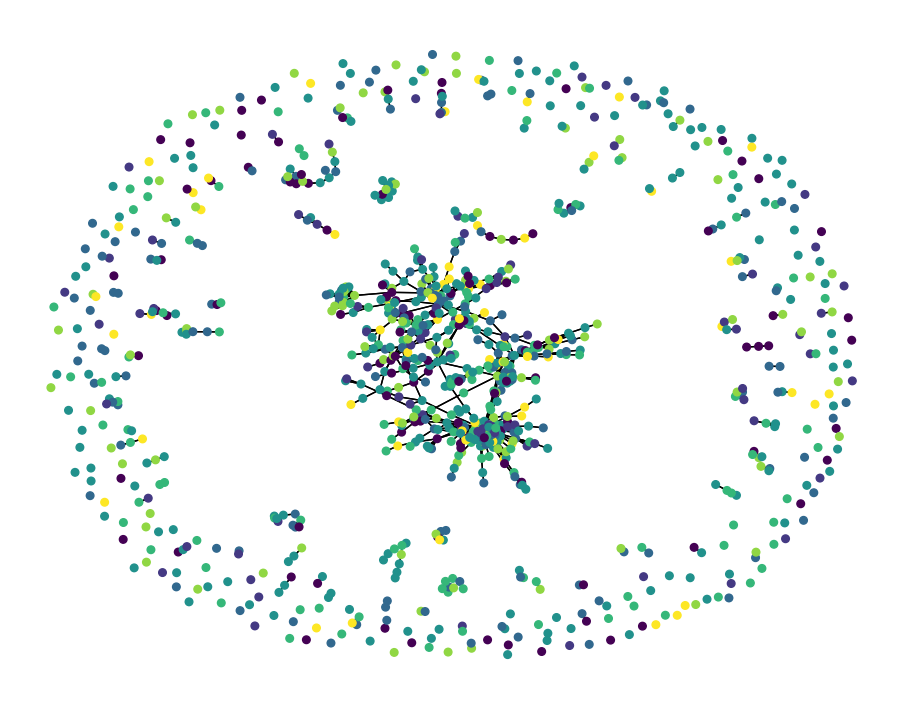

In [9]:
import random
from torch_geometric.utils import to_networkx
import networkx as nx

def convert_to_networkx(graph, n_sample=None):

    g = to_networkx(graph, node_attrs=["x"])
    y = graph.y.numpy()

    if n_sample is not None:
        sampled_nodes = random.sample(g.nodes, n_sample)
        g = g.subgraph(sampled_nodes)
        y = y[sampled_nodes]

    return g, y


def plot_graph(g, y):

    plt.figure(figsize=(9, 7))
    nx.draw_spring(g, node_size=30, arrows=False, node_color=y)
    plt.show()


g, y = convert_to_networkx(graph, n_sample=1000)
plot_graph(g, y)

#Node Classification

For the node classification problem, we are splitting the nodes into train, valid, and test using the RandomNodeSplit module from PyG (we are replacing the original split masks in the data as it has a too small train set).

In [10]:
graph

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [13]:

import torch_geometric.transforms as T

# Set a fixed seed for reproducibility
torch.manual_seed(42)  # You can use any integer as the seed

split = T.RandomNodeSplit(num_val=0.1, num_test=0.2)
graph = split(graph)

In [14]:
graph

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

###visualize train test validation

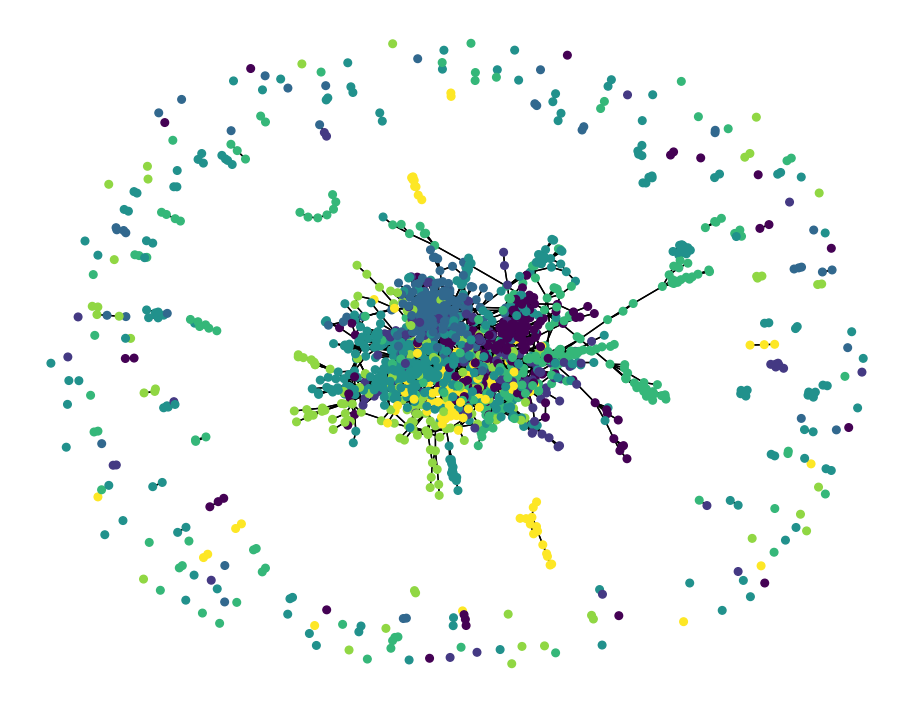

In [19]:
import random
from torch_geometric.utils import to_networkx
import networkx as nx

def convert_to_networkx(graph, n_sample=None):

    g = to_networkx(graph, node_attrs=["x"])
    y = graph.y.numpy()

    if n_sample is not None:
        sampled_nodes = random.sample(g.nodes, n_sample)
        g = g.subgraph(sampled_nodes)
        y = y[sampled_nodes]

    return g, y


def plot_graph_for_nodes(g, y, nodes):

    plt.figure(figsize=(9, 7))
    subgraph = g.subgraph(nodes)
    nx.draw_spring(subgraph, node_size=30, arrows=False, node_color=[y[node] for node in subgraph.nodes])
    plt.show()

# Assuming you have 'graph' and 'train_nodes' defined
g, y = convert_to_networkx(graph)
plot_graph_for_nodes(g, y, train_nodes)


##GCN on Node Classification

In [ ]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        output = self.conv2(x, edge_index)

        return output


gcn = GCN().to(device)
optimizer_gcn = torch.optim.Adam(gcn.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
gcn = train_node_classifier(gcn, graph, optimizer_gcn, criterion)

test_acc = eval_node_classifier(gcn, graph, graph.test_mask)
print(f'Test Acc: {test_acc:.3f}')